# 7. Pipelines and Transformers

This notebook showcases the current version of data processing pipelines in CapyMOA. 

* Includes an example of how preprocessing can be accomplished via pipelines and transformers.
* Transformers transform an instance, e.g., using standardization, normalization, etc.
* Pipelines bundle transformers and can also act as classifiers or regressors

<span style="color:red"><b>Please note that this feature is still under development; some functionality might not yet be available or change in future releases.</b></span>

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**notebook last updated on 25/07/2024**

## 1. Running onlineBagging without any preprocessing

First, let us have a look at a simple test-then-train classification example without pipelines. 
- We loop over the instances of the data stream
- make a prediction,
- update the evaluator with the prediction and label
- and then train the classifier on the instance.

In [1]:
## Test-then-train loop
from capymoa.datasets import Electricity
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import ClassificationEvaluator

## Opening a file as a stream
elec_stream = Electricity()

# Creating a learner
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    
    prediction = ob_learner.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    ob_learner.train(instance)

ob_evaluator.accuracy()

82.06656073446328

## 2. Online Bagging using pipelines and transformers

If we want to perform some preprocessing, such as normalization or feature transformation, or a combination of both, we can chain multiple such `Transformer`s within a pipeline. The last step of a pipeline is a learner, such as capymoa classifier or regressor.

Similar as classifiers and regressors, pipelines support `train` and `test`. Hence, we can use them in the same way as we would use other capymoa learners. Internally, the pipeline object passes an incoming instance from one transformer to the next. It then returns the prediction of the classifier / regressor using the transformed instance.

Creating a pipeline consists of the following steps:
1. Create a stream instance
2. Initialize the transformers
3. Initialize the learner
4. Create the pipeline. Here, we use a `ClassifierPipeline`
5. Use the pipeline the same way as any other learner.

In [2]:
from capymoa.stream.preprocessing import MOATransformer
from capymoa.stream.preprocessing import ClassifierPipeline
from capymoa.stream import Stream
from moa.streams.filters import AddNoiseFilter, NormalisationFilter
from moa.streams import FilteredStream

elec_stream = Electricity()

# Creating the transformers
normalisation_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=NormalisationFilter())
add_noise_transformer = MOATransformer(schema=normalisation_transformer.get_schema(), moa_filter=AddNoiseFilter())

# Creating a learner
ob_learner = OnlineBagging(schema=add_noise_transformer.get_schema(), ensemble_size=5)

# Creating and populating the pipeline
pipeline = ClassifierPipeline(transformers=[normalisation_transformer, add_noise_transformer],
                              learner=ob_learner)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema()) 

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)

ob_evaluator.accuracy()

77.5048552259887

We can also get a textual representation of the pipeline:

In [3]:
str(pipeline)

'Transformer(NormalisationFilter) | Transformer(AddNoiseFilter) | OnlineBagging'

### 2.1 Alternative syntax
* An alternative syntax to define the pipeline is shown below
* Since the pipeline behaves like a learner, it can be used with high-level evaluation functions like `prequential_evaluation`

AdaptiveRandomForest: 88.55049435028248
Transformer(NormalisationFilter) | AdaptiveRandomForest: 88.07821327683615


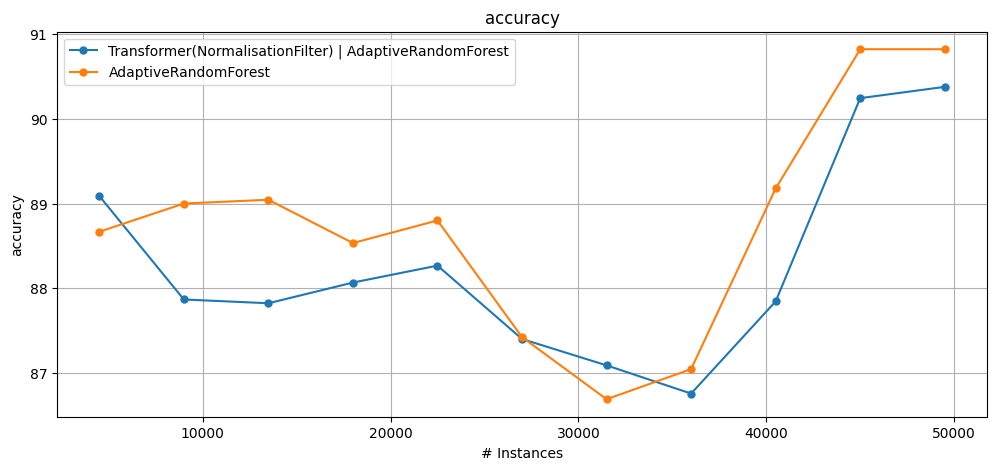

In [4]:
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import AdaptiveRandomForestClassifier
from capymoa.evaluation.visualization import plot_windowed_results

elec_stream = Electricity()

# Creating a transformer
normalisation_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=NormalisationFilter())

# Creating an ARF classifier as a baseline
arf = AdaptiveRandomForestClassifier(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Alternative syntax. 
pipeline_arf = ClassifierPipeline()
pipeline_arf.add_transformer(normalisation_transformer)
pipeline_arf.set_learner(AdaptiveRandomForestClassifier(schema=add_noise_transformer.get_schema(), ensemble_size=5))

results_arf_pipeline = prequential_evaluation(stream=elec_stream, learner=pipeline_arf, window_size=4500)
results_arf_baseline = prequential_evaluation(stream=elec_stream, learner=arf, window_size=4500)

print(f"{arf}: {results_arf_baseline['cumulative'].accuracy()}")
print(f"{pipeline_arf}: {results_arf_pipeline['cumulative'].accuracy()}")
plot_windowed_results(results_arf_pipeline, results_arf_baseline, metric='accuracy')

## 3. RegressorPipeline

* The regression version of the pipeline is quite similar to the classification one

In [8]:
from capymoa.regressor import AdaptiveRandomForestRegressor
from capymoa.stream.preprocessing import RegressorPipeline
from capymoa.evaluation import RegressionEvaluator
from capymoa.datasets import Fried

fried_stream = Fried()

# Creating a transformer
normalisation_transformer = MOATransformer(schema=fried_stream.get_schema(), moa_filter=NormalisationFilter())

arfreg = AdaptiveRandomForestRegressor(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Creating and populating the pipeline
pipeline_arfreg = RegressorPipeline(transformers=[normalisation_transformer],
                              learner=arfreg)

# Creating the evaluator
arfreg_evaluator = RegressionEvaluator(schema=fried_stream.get_schema()) 

while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = pipeline_arfreg.predict(instance)
    arfreg_evaluator.update(instance.y_value, prediction)
    pipeline_arfreg.train(instance)

print(f"rmse: {arfreg_evaluator.rmse()}")

rmse: 2.5841013025710358
